In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
rs=121
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [3]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'
#train, test = train_test_split(data,test_size=0.2,shuffle=True,random_state=rs,stratify=data['State'])

In [4]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
stocks_data=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    stocks_data.append(x[1][:-ft_size])
#Model Training
#model=
#model.fit(x=train_x,y=train_y)
#Model Prediction and Accuracy
#accuracy_score(test_y,model.predict(test_x))


In [102]:
def create_sliding_window(train_df, test_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y, test_x, test_y = [], [], [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    for idx in splitter.split(test_df):
        X = test_df.iloc[idx[0]][features].values.flatten()
        y = test_df.iloc[idx[1]][target].values.flatten()[0]
        test_x.append(X)
        test_y.append(y)

    return (train_x, train_y), (test_x, test_y)


In [5]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

Skip the three cells below if you have access to the saved training windows

training_lists is a dictionary with keys as spread, that is window size for model fitting.

training_list is a dictionary which gets assigned as value for training_lists.

training_list is a dictionary with stocks as keys and values as list. This list is nested as consists of pairs.

For ex, training_lists[3] would be a dictionary showing stock-wise rolling windows.

training_lists[3][0] would consist of a nested list, associated to rolling windows of size 3 and for the Apple stock.

training_lists[3][0] = [rolling windows for training (each of them is a list),rolling state for the next day(each of them a singleton list)]

In [ ]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    training_lists[spread] = {}
    testing_lists[spread] = {}
    for ticker_idx, ticker_df in enumerate(stocks_data):
        ticker = list(ticker_df["Ticker"])[0]
        training_list = [[[], []] for _ in range(ns)]
        testing_list = [[[], []] for _ in range(ns)]
        for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
            train_df = ticker_df.iloc[train_idx]
            test_df = ticker_df.iloc[test_idx]           
            (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
            training_list[fold_idx][0] += train_x
            training_list[fold_idx][1] += train_y
            testing_list[fold_idx][0] += test_x
            testing_list[fold_idx][1] += test_y
        training_lists[spread][stocks.index(ticker)] = training_list
        testing_lists[spread][stocks.index(ticker)] = testing_list #spread->stock index->time series split->data/label

In [117]:
with open('saved_training_lists.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)

Load training, test windows here. 
They're saved for complexity reasons, RUN CODE from here

In [6]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [7]:
import optuna
def objective_with_args(spread, stock_ind):
    def inner(trial):
        param = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1.0]),
            'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1.0, 2.0, 5.0]),
            'min_split_loss': trial.suggest_categorical('min_split_loss', [0, 0.1, 0.3, 0.5]),
            "tree_method": "hist",
            "device": "cuda",
        }
        model = XGBClassifier(**param)
        a = 0
        training_list = training_lists[spread][stock_ind]
        testing_list = testing_lists[spread][stock_ind]
        for i in range(ns):
            model.fit(X=training_list[i][0], y=training_list[i][1])
            a += accuracy_score(model.predict(testing_list[i][0]), testing_list[i][1])
        a = a / ns
        return a
    return inner


from functools import partial

best_XGB = {}
for spread in spread_range:
    best_XGB[spread] = {}
    for s_ind in range(len(stocks)):
        study = optuna.create_study(direction="maximize")
        study.optimize(objective_with_args(spread, s_ind), n_trials=50)
        
        best_params = study.best_params
        best_XGB[spread][s_ind] = XGBClassifier(**best_params, tree_method="hist", device="cuda")

[I 2025-04-12 18:31:06,296] A new study created in memory with name: no-name-bb736c09-c454-483e-83eb-89554ea0416a
c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:31:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-04-12 18:31:10,782] Trial 0 finished with value: 0.8405622489959839 and parameters: {'max_depth': 8, 'learning_rate': 0.16274639538102562, 'n_estimators': 238, 'subsample': 0.5518832468783684, 'colsample_bytree': 0.7737469846215037, 'reg_alpha': 0, 'reg_lambda': 2.0, 'min_split

In [8]:
with open('saved_xgb.pkl', 'wb') as f:
    pickle.dump(best_XGB, f)

In [ ]:
# from copy import deepcopy
# def accuracies_model(model):
#     init_model = deepcopy(model) #saving deepcopy to reinitalize the model after training on a stock
#     accuracies = {}
#     for window in training_lists.keys():
#         model = deepcopy(init_model) #initialize model for every iteration
#         accuracies[window]= {}
#         for stock_ind in range(len(stocks)):
#             a=0 
#             for i in range(ns):
#                 model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
#                 a+= accuracy_score(model.predict(testing_lists[window][stock_ind][i][0]),testing_lists[window][stock_ind][i][1])
#             a=a/ns
#             accuracies[window][stock_ind] = a
#             model = deepcopy(init_model) #reset model after training on a stock
#     return accuracies

In [16]:
def accuracies_model(model_dict, window, stock_ind, map=True):
    a=0 
    if map:
        model = model_dict[window][stock_ind]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
        a+= accuracy_score(model.predict(testing_lists[window][stock_ind][i][0]),testing_lists[window][stock_ind][i][1])
    a=a/ns
    return a

In [ ]:
def plot_accuracies(accuracies, model_type): #accuracies needs to be a nested dictionary window->stock index
    for stock_ind in range(len(stocks)):
        vals = []
        for window in accuracies.keys():
            vals.append(accuracies[window][stock_ind])
        plt.figure(figsize=(6, 4))
        plt.plot(list(accuracies.keys()), vals, marker='o')
        plt.title(f"{model_type} accuracy scores for {stocks[stock_ind]}")
        plt.xlabel("Window size")
        plt.ylabel("accuracy")
        plt.tight_layout()
        plt.show()

Repeat the cell below to generate plots

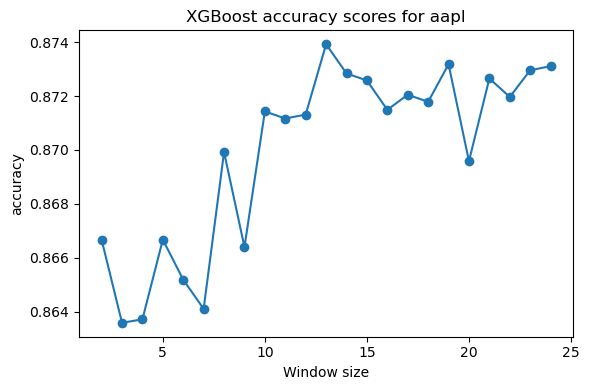

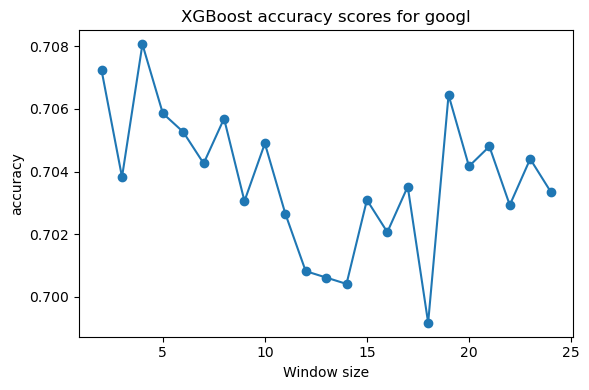

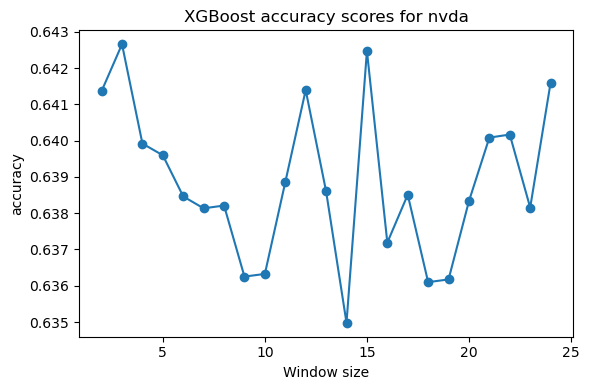

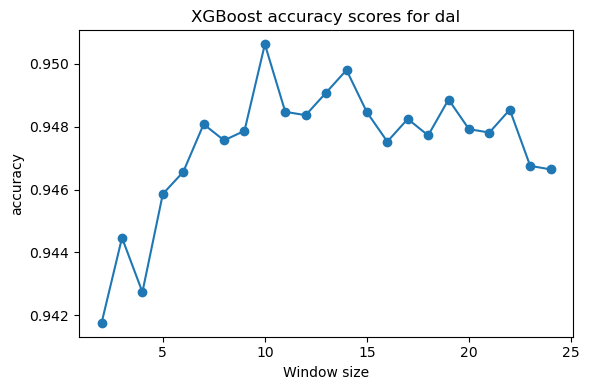

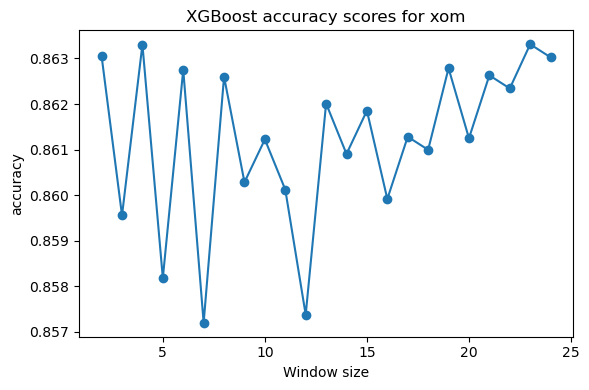

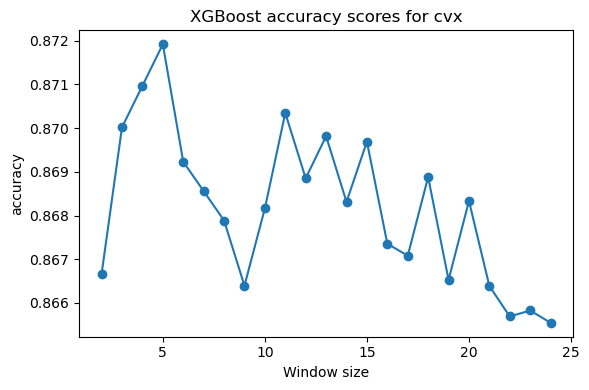

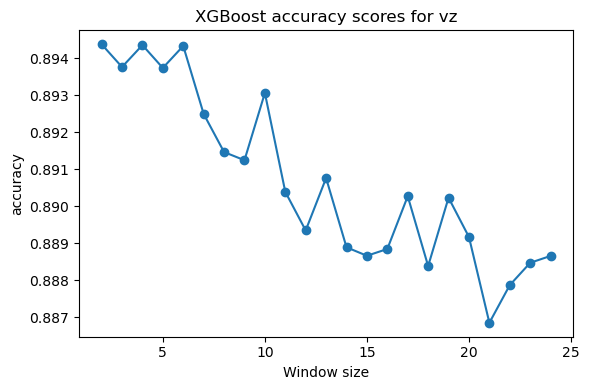

In [14]:
accuracies_xgb = {}
for window in spread_range:
    accuracies_xgb[window] = {}
    for stock_ind in range(len(stocks)):
        accuracies_xgb[window][stock_ind] = accuracies_model(best_XGB,window,stock_ind)

plot_accuracies(accuracies_xgb, "XGBoost")

In [ ]:
accuracies_ada = {}
for window in spread_range:
    accuracies_ada[window] = {}
    for stock_ind in range(len(stocks)):
        ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
        accuracies_ada[window][stock_ind] = accuracies_model(ada_model,window,stock_ind,map=False)
plot_accuracies(accuracies_ada, "Ada Boost")

In [ ]:
accuracies_decision = {}
for window in spread_range:
    accuracies_decision[window] = {}
    for stock_ind in range(len(stocks)):
        decision_model = DecisionTreeClassifier(random_state=rs)
        accuracies_decision[window][stock_ind] = accuracies_model(decision_model,window,stock_ind,map=False)
plot_accuracies(accuracies_decision, "Decision Tree")

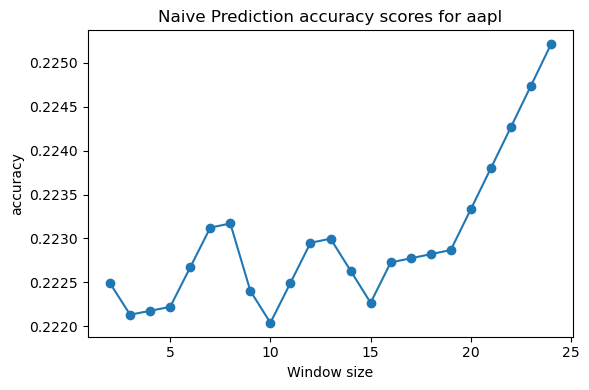

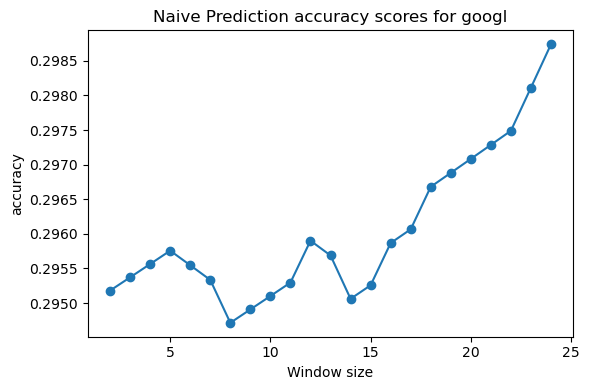

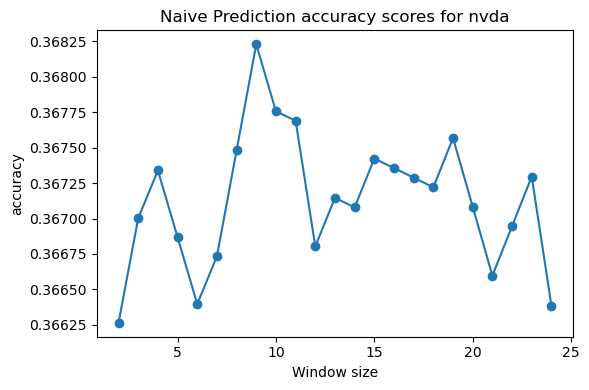

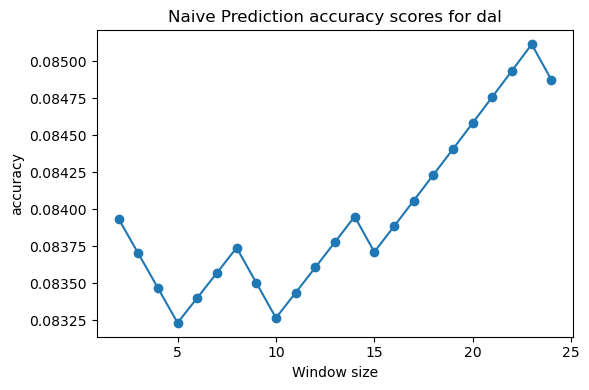

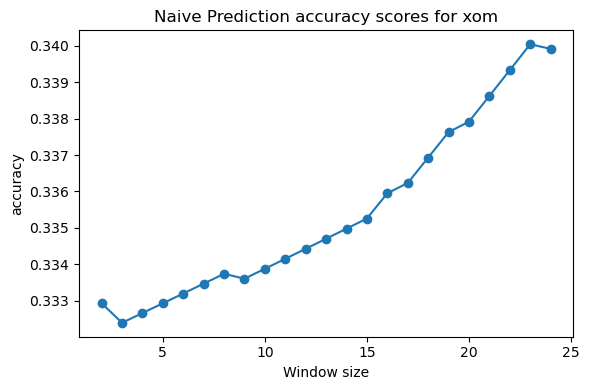

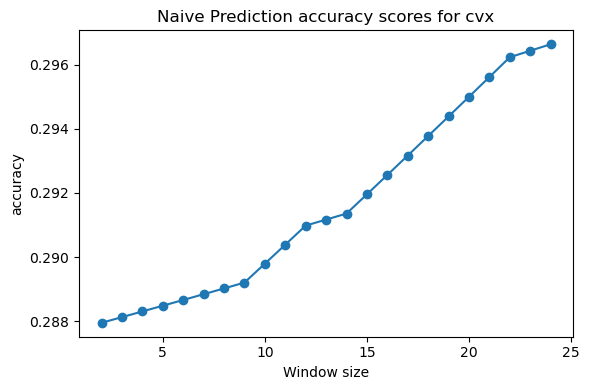

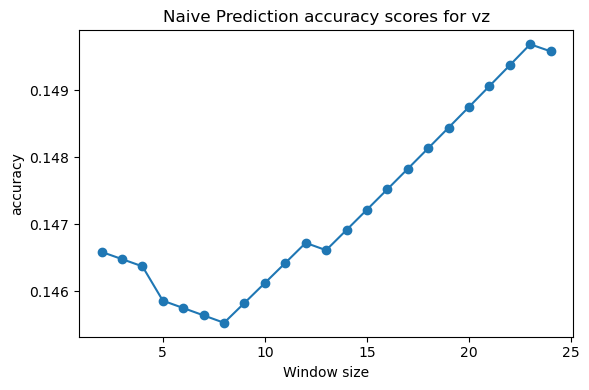

In [15]:
#Naive Prediction
accuracies = {}
for window in spread_range:
    accuracies[window] = {}
    for s_ind in range(len(stocks)):
        testing_list = testing_lists[window][s_ind]
        testing_list = testing_lists[window][s_ind]
        a=0 
        for i in range(ns):
            a+= accuracy_score([1]*len(testing_list[i][1]),testing_list[i][1])
        a=a/ns
        accuracies[window][s_ind] = a
plot_accuracies(accuracies, "Naive Prediction")

In [ ]:
from copy import deepcopy
model_forest = RandomForestClassifier(
    n_estimators = 100, # number of trees in ensemble
    max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 5, # default is round(sqrt(num_features)), which in this case is 1.
    random_state = 121 # for consistency
    )

# accuracies_rfc = {}
# for window in training_lists.keys():
#     training_list = training_lists[window]
#     testing_list = testing_lists[window]
#     a=0 
#     for i in range(ns):
#         model.fit(X=training_list[i][0],y=training_list[i][1])
#         a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
#     a=a/ns
#     accuracies_rfc[window] = a

In [ ]:
accuracies_rfc = {}
for window in spread_range:
    accuracies_decision[window] = {}
    for stock_ind in range(len(stocks)):
        rfc_model = deepcopy(model_forest)
        accuracies_decision[window][stock_ind] = accuracies_model(rfc_model,window,stock_ind,map=False)
plot_accuracies(accuracies_decision, "Decision Tree")